In [1]:
import os
import xscen as xs
import xarray as xr
import xclim as xc
from pathlib import Path
import figanos.matplotlib as fg

fg.utils.set_mpl_style("ouranos")

ERROR 1: PROJ: proj_create_from_database: Open of /exec/abuyalo/.conda/envs/jupyter_clone/share/proj failed


In [2]:
user = os.getlogin()

# Prepare a dummy folder where data will be put
output_folder = Path("/") / "exec" / user / "data"
output_folder.mkdir(exist_ok=True)

In [3]:
path_reconstruction = "/tank/scenario/catalogues/reconstruction.json"

# Les paths qui pointent au catalogues dans "tank/scenario/catalogues/" ne changent pas? Oui
# Les paths (contenus dans les jsons) qui pointent au datasets, peuvent changer? Oui

## All reconstruction catalogs

In [4]:
DC = xs.DataCatalog(path_reconstruction)
DC.df[["id","institution","experiment","path"]]

,id,institution,experiment,path
0,ECMWF_ERA5-Land_NAM,ECMWF,NaN,/tank/scenario/datasets/reconstruction/NAM/ECM...
1,ECMWF_ERA5-Land_NAM,ECMWF,NaN,/tank/scenario/datasets/reconstruction/NAM/ECM...
2,ECMWF_ERA5-Land_NAM,ECMWF,NaN,/tank/scenario/datasets/reconstruction/NAM/ECM...
3,ECMWF_ERA5-Land_NAM,ECMWF,NaN,/tank/scenario/datasets/reconstruction/NAM/ECM...
4,ECMWF_ERA5-Land_NAM,ECMWF,NaN,/tank/scenario/datasets/reconstruction/NAM/ECM...
...,...,...,...,...
549,USask_EMDNA_032_NAM,USask,NaN,/jarre/scenario/datasets/reconstruction/NAM/US...
550,USask_EMDNA_032_NAM,USask,NaN,/jarre/scenario/datasets/reconstruction/NAM/US...
551,USask_EMDNA_038_NAM,USask,NaN,/jarre/scenario/datasets/reconstruction/NAM/US...
552,USask_EMDNA_038_NAM,USask,NaN,/jarre/scenario/datasets/reconstruction/NAM/US...


In [5]:
DC.unique("institution")

['ECMWF', 'GovCan', 'USask']

## Searching catalogs for daily maximum temperature

In [6]:
variables_and_freqs = {"tasmax": "D"}
other_search_criteria = {"institution": ["ECMWF"]}

cat_sim = xs.search_data_catalogs(
    data_catalogs=[path_reconstruction],
    variables_and_freqs=variables_and_freqs,
    other_search_criteria=other_search_criteria
)

cat_sim

{'ECMWF_ERA5-Land_NAM': < catalog with 1 dataset(s) from 1 asset(s)>,
 'ECMWF_ERA5_NAM': < catalog with 1 dataset(s) from 2 asset(s)>}

## Extracting dataset

In [7]:
ds_dict = xs.extract_dataset(
    catalog=cat_sim["ECMWF_ERA5-Land_NAM"],
    variables_and_freqs=variables_and_freqs
)

ds_dict

{'D': <xarray.Dataset> Size: 143GB
 Dimensions:  (lat: 801, lon: 1700, time: 26298)
 Coordinates:
   * lat      (lat) float32 3kB 10.0 10.1 10.2 10.3 10.4 ... 89.7 89.8 89.9 90.0
   * lon      (lon) float32 7kB -179.9 -179.8 -179.7 -179.6 ... -10.2 -10.1 -10.0
   * time     (time) datetime64[ns] 210kB 1950-01-01 1950-01-02 ... 2021-12-31
 Data variables:
     tasmax   (time, lat, lon) float32 143GB dask.array<chunksize=(1461, 50, 50), meta=np.ndarray>
 Attributes: (12/33)
     Conventions:             CF-1.9
     cell_methods:            time: maximum (interval: 1 day)
     doi:                     https://doi.org/10.24381/cds.e2161bac
     domain:                  NAM
     frequency:               day
     history:                 [2022-12-25 09:07:39.901698] Converted variables...
     ...                      ...
     cat:variable:            tasmax
     cat:domain:              NAM
     cat:date_start:          1950-01-01 00:00:00
     cat:date_end:            2021-12-31 23:00:00
 

In [66]:
print(ds_dict['D'].attrs['cell_methods'])
print(ds_dict['D'].tasmax.attrs['cell_methods'])

time: maximum (interval: 1 day)
time: point


## Saving dataset

In [9]:
ds = ds_dict['D']
filename = str(
    output_folder
    / f"{ds.attrs['cat:id']}.{ds.attrs['cat:domain']}.{ds.attrs['cat:processing_level']}.{ds.attrs['cat:frequency']}.zarr"
)
chunks = xs.io.estimate_chunks(ds, dims=["time"], target_mb=50)
xs.save_to_zarr(ds, filename, rechunk=chunks, mode="o")
print(filename)

/exec/abuyalo/data/ECMWF_ERA5-Land_NAM.NAM.extracted.day.zarr


## Yearly means of daily temperature

In [12]:
mtl_lat = 45.50884
mtl_lon = -73.58781

In [48]:
ds = xr.open_zarr(filename)
ds.tasmax

<xarray.DataArray 'tasmax' (time: 26298, lat: 801, lon: 1700)> Size: 143GB
dask.array<open_dataset-tasmax, shape=(26298, 801, 1700), dtype=float32, chunksize=(10, 801, 1700), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB 10.0 10.1 10.2 10.3 10.4 ... 89.7 89.8 89.9 90.0
  * lon      (lon) float32 7kB -179.9 -179.8 -179.7 -179.6 ... -10.2 -10.1 -10.0
  * time     (time) datetime64[ns] 210kB 1950-01-01 1950-01-02 ... 2021-12-31
Attributes:
    cell_methods:       time: point
    long_name:          2 metre temperature
    original_variable:  t2m
    standard_name:      air_temperature
    units:              K

In [53]:
ds_mtl = ds.sel(lat=mtl_lat, lon=mtl_lon, method="nearest") # Selecting the closest grid point to Montreal

In [68]:
tasmax_mtl_yearly = xc.indicators.atmos.tx_mean(tasmax=ds_mtl.tasmax, freq="YS") # Averaging daily temperature for each year (Using xclim)

/exec/abuyalo/.conda/envs/jupyter_clone/lib/python3.11/site-packages/xclim/core/cfchecks.py:43: UserWarning: Variable has a non-conforming cell_methods: Got `time: point`, which do not include the expected `time: maximum`.


## Plotting

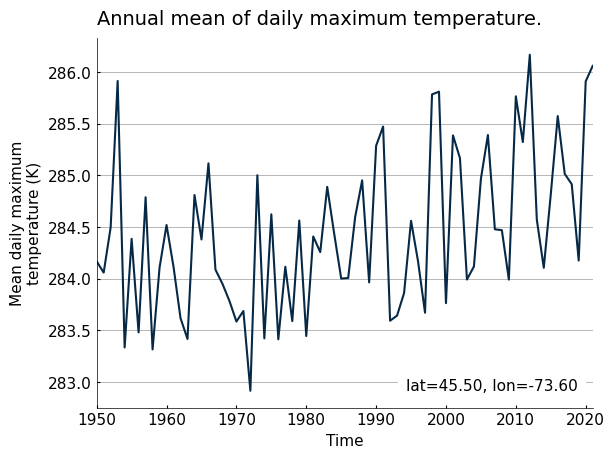

In [51]:
ax = fg.timeseries(tasmax_mtl_yearly)

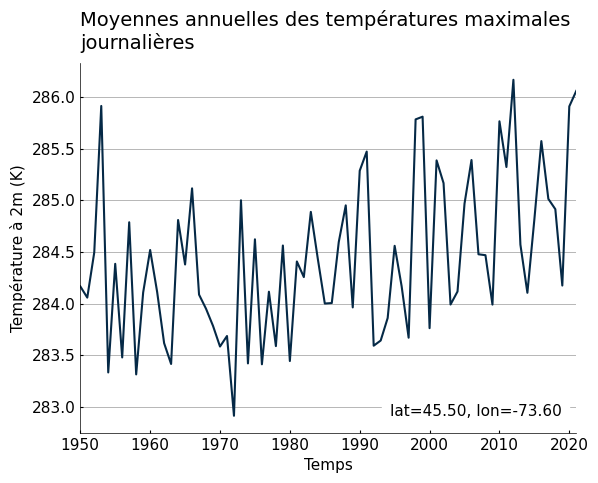

In [52]:
tasmax_mtl_yearly.attrs.update(
    description_fr="Moyennes annuelles des températures maximales journalières",
    long_name_fr="Température maximale journalière moyenne"
)

with xc.set_options(metadata_locales=["fr"]):
    ax = fg.timeseries(tasmax_mtl_yearly)